# Transfer Learning with TensorFlow: Feature Extraction

## 1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (`mobilenet_v2_100_224/feature_vector`) from TensorFlow Hub, how does it perform compared to our other models?

### Prep Models

In [1]:

# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-02-23 00:40:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 64.233.182.128, 64.233.183.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   167MB/s    in 1.0s    

2023-02-23 00:40:36 (167 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [3]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [4]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [6]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [7]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [8]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:

# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230223-004048
Epoch 1/5
24/24 [==============================] - 31s 793ms/step - loss: 2.0783 - accuracy: 0.3267 - val_loss: 1.2969 - val_accuracy: 0.5836
Epoch 2/5
24/24 [==============================] - 17s 746ms/step - loss: 0.9707 - accuracy: 0.7040 - val_loss: 0.8813 - val_accuracy: 0.7204
Epoch 3/5
24/24 [==============================] - 16s 702ms/step - loss: 0.6606 - accuracy: 0.7987 - val_loss: 0.7610 - val_accuracy: 0.7596
Epoch 4/5
24/24 [==============================] - 17s 709ms/step - loss: 0.5033 - accuracy: 0.8707 - val_loss: 0.7151 - val_accuracy: 0.7648
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.4104 - accuracy: 0.9067 - val_loss: 0.6795 - val_accuracy: 0.7756


In [10]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

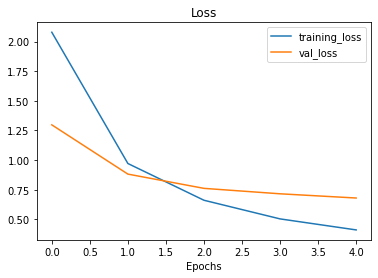

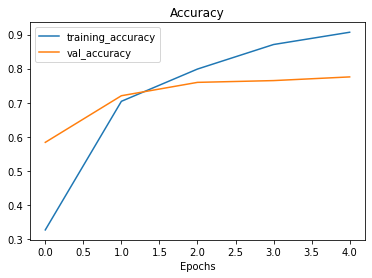

In [11]:
plot_loss_curves(resnet_history)

In [12]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230223-004300
Epoch 1/5
24/24 [==============================] - 28s 761ms/step - loss: 1.8555 - accuracy: 0.4307 - val_loss: 1.2836 - val_accuracy: 0.7272
Epoch 2/5
24/24 [==============================] - 16s 669ms/step - loss: 1.0550 - accuracy: 0.7907 - val_loss: 0.8543 - val_accuracy: 0.8256
Epoch 3/5
24/24 [==============================] - 16s 670ms/step - loss: 0.7474 - accuracy: 0.8453 - val_loss: 0.6890 - val_accuracy: 0.8464
Epoch 4/5
24/24 [==============================] - 16s 667ms/step - loss: 0.6009 - accuracy: 0.8760 - val_loss: 0.6066 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 17s 715ms/step - loss: 0.5061 - accuracy: 0.9000 - val_loss: 0.5546 - val_accuracy: 0.8644


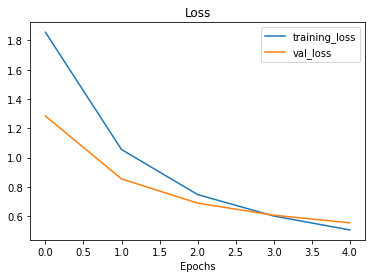

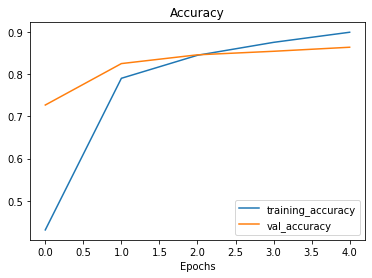

In [14]:
plot_loss_curves(efficientnet_history)

In [15]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [16]:
# # Check out experiments
# !tensorboard dev list

In [17]:
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#   --name "EfficientNetB0 vs. ResNet50V2" \
#   --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
#   --one_shot

### Main Model (mobilenet_v2_100_224/feature_vector)

In [18]:
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"


In [19]:
# Create model
mobilenet_model = create_model(mobilenet_url, num_classes=train_data_10_percent.num_classes)

# Compile
mobilenet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [20]:
# Fit EfficientNet model 
mobilenet_history = mobilenet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="mobilenet_v2_100_224")])                                                                         

Saving TensorBoard log files to: tensorflow_hub/mobilenet_v2_100_224/20230223-004435
Epoch 1/5
24/24 [==============================] - 20s 690ms/step - loss: 1.8928 - accuracy: 0.3480 - val_loss: 1.2656 - val_accuracy: 0.6300
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.9867 - accuracy: 0.7200 - val_loss: 0.8636 - val_accuracy: 0.7384
Epoch 3/5
24/24 [==============================] - 16s 675ms/step - loss: 0.6966 - accuracy: 0.8160 - val_loss: 0.7465 - val_accuracy: 0.7708
Epoch 4/5
24/24 [==============================] - 16s 689ms/step - loss: 0.5508 - accuracy: 0.8720 - val_loss: 0.6872 - val_accuracy: 0.7788
Epoch 5/5
24/24 [==============================] - 15s 663ms/step - loss: 0.4519 - accuracy: 0.9027 - val_loss: 0.6406 - val_accuracy: 0.7968


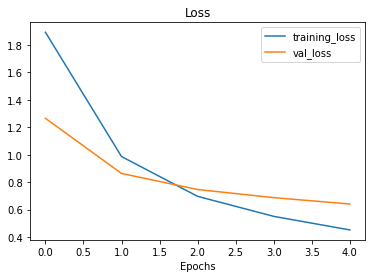

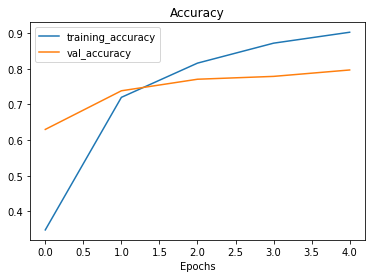

In [21]:
plot_loss_curves(mobilenet_history)

In [22]:
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


## 2. Name 3 different image classification models on TensorFlow Hub that we haven't used.

Answer:
* Inception V1
* NASNET-A
* RegNetY

## 3. Build a model to classify images of two different things you've taken photos of.
* You can use any feature extraction layer from TensorFlow Hub you like for this.
* You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.

### Functions

In [23]:
import os
import numpy as np
import tensorflow as tf

In [24]:
def create_binary_model(model_url):

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(1, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

In [25]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [26]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# images must be saved sub folders of their class
def get_images_labels(target_dir, class_names, resize=None):
  # Setup target directory (we'll view images from here)
  labels = []
  imgs = []
  for idx, class_dir in enumerate(class_names):
    target_folder = target_dir+class_dir

    for img_file in os.listdir(target_folder):
      img = cv2.imread(target_folder + "/" + img_file)
      if resize: img = cv2.resize(img, resize)
      imgs.append(img)

      labels.append(idx)

  return (np.array(imgs), np.array(labels))

In [27]:
# view any image (at idx) from (imgs, labels) as output by "get_images_labels" function 
def view_image(imgs, labels, idx, class_names):
  img = imgs[idx]
  plt.imshow(img)
  plt.title(class_names[labels[idx]])
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image



In [28]:
# view any image at random index from (imgs, labels) as output by "get_images_labels" function 
def view_random_image(imgs, labels, class_names):
  idx = np.random.randint(len(imgs))

  img = imgs[idx]
  plt.imshow(img)

  shp = labels.shape
  label_idx = labels[idx]  
  if len(shp)==2: # if one hot encoded
    label_idx = tf.where(label_idx==1)[0][0]

  plt.title(class_names[label_idx])
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image


In [29]:
def pred_and_plot(model, imgs, class_names):
  idx = np.random.randint(len(imgs))

  img = imgs[idx]

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))[0]

  # Get the predicted class
  if len(pred)==1: 
    print(pred)
    pred_class = class_names[round(pred[0])]
  else:
    pred_class = class_names[int(tf.argmax(pred))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [30]:
# will split images and labels into training and test (or validation) data
# images must be array length N x w x h x 3.
# labels must be Nx1 (sparse) or Nxdepth (not sparse)
# All images and labels must be in synchronous.
# There must be same number images for each label.
# All images must be ordered by label, where all images from first label come first, then
# all images from second label come second, and so on
# depth is number of classes
# split must be split size; data will be shuffled prior to split
def images_labels_split(imgs, lbls, depth, split=.2):
  train_imgs = []
  train_lbls = []
  
  test_imgs = []
  test_lbls = []

  N = len(imgs)
  
  if N!=len(lbls): raise Exception

  # size of images for each label
  n = int(N/depth)

  for k in range(depth):
    
    inds = np.linspace(0, n-1, n)
    np.random.shuffle(inds)

    ind_split = n - int(n*split)
    train_inds = inds[:ind_split]
    test_inds = inds[ind_split:]
    
    for train_ind in train_inds:
      train_ind = int(train_ind+k*n)
      train_imgs.append(imgs[train_ind])
      train_lbls.append(lbls[train_ind])


    for test_ind in test_inds:
      test_ind = int(test_ind+k*n)
      test_imgs.append(imgs[test_ind])
      test_lbls.append(lbls[test_ind])

  return (np.array(train_imgs), np.array(train_lbls), np.array(test_imgs), np.array(test_lbls))

### Two classes: Lambos and Rraris

In [31]:
parent_dir = '/content/drive/MyDrive/lambo_rrari/'

In [32]:
class_names = ['lambo', 'rrari']
(X, Y) = get_images_labels(parent_dir, class_names, resize=(224, 224))
# Y = tf.one_hot(Y, 6) # no need to one hot encode for binary

In [33]:
X_train, Y_train, X_test, Y_test = images_labels_split(X, Y, depth=2, split=.2)

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.)


In [35]:
train_data = datagen.flow(X_train, Y_train, batch_size=32, seed=42)
test_data = datagen.flow(X_test, Y_test, batch_size=32, seed=42)

In [36]:
# Create model
efficientnet_lambo_rrari_model = create_binary_model(model_url=efficientnet_url)

# Compile EfficientNet model
efficientnet_lambo_rrari_model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_lambo_rrari_history = efficientnet_lambo_rrari_model.fit(train_data, # only use 10% of training data
                                              epochs=20, # train for 5 epochs
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0_lambo_rrari")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0_lambo_rrari/20230223-004621
Epoch 1/20
5/5 [==============================] - 12s 465ms/step - loss: 0.6859 - accuracy: 0.5875 - val_loss: 0.6843 - val_accuracy: 0.5500
Epoch 2/20
5/5 [==============================] - 0s 91ms/step - loss: 0.6451 - accuracy: 0.6875 - val_loss: 0.6594 - val_accuracy: 0.6500
Epoch 3/20
5/5 [==============================] - 0s 94ms/step - loss: 0.6149 - accuracy: 0.7563 - val_loss: 0.6398 - val_accuracy: 0.6250
Epoch 4/20
5/5 [==============================] - 0s 90ms/step - loss: 0.5833 - accuracy: 0.8062 - val_loss: 0.6198 - val_accuracy: 0.7500
Epoch 5/20
5/5 [==============================] - 0s 98ms/step - loss: 0.5605 - accuracy: 0.8062 - val_loss: 0.6021 - val_accuracy: 0.7500
Epoch 6/20
5/5 [==============================] - 0s 104ms/step - loss: 0.5347 - accuracy: 0.8125 - val_loss: 0.5867 - val_accuracy: 0.7250
Epoch 7/20
5/5 [==============================] - 0s 92ms/step - loss: 0

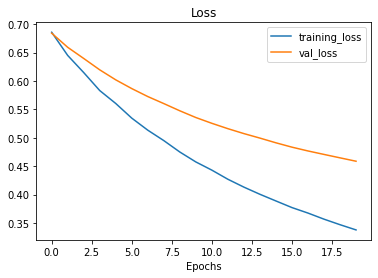

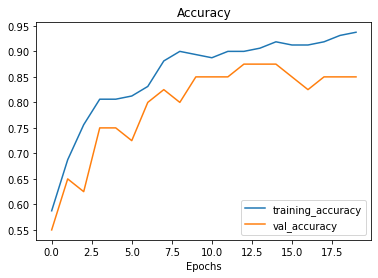

In [37]:
plot_loss_curves(efficientnet_lambo_rrari_history)

In [38]:
efficientnet_lambo_rrari_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 1,281
Non-trainable params: 4,049,564
_________________________________________________________________


In [39]:
X_test

array([[[[111, 104,  87],
         [111, 104,  87],
         [111, 104,  87],
         ...,
         [ 99,  91,  74],
         [ 99,  92,  75],
         [ 99,  92,  75]],

        [[111, 104,  87],
         [111, 104,  87],
         [111, 104,  87],
         ...,
         [ 99,  92,  75],
         [100,  93,  76],
         [100,  93,  76]],

        [[111, 105,  88],
         [111, 105,  88],
         [111, 105,  88],
         ...,
         [100,  93,  76],
         [100,  94,  76],
         [100,  94,  76]],

        ...,

        [[250, 250, 250],
         [250, 250, 250],
         [250, 250, 250],
         ...,
         [250, 250, 250],
         [250, 250, 250],
         [250, 250, 250]],

        [[250, 250, 250],
         [250, 250, 250],
         [250, 250, 250],
         ...,
         [250, 250, 250],
         [250, 250, 250],
         [250, 250, 250]],

        [[250, 250, 250],
         [250, 250, 250],
         [250, 250, 250],
         ...,
         [250, 250, 250],
        

In [40]:

efficientnet_lambo_rrari_model.predict(X_test/255.)

2/2 [==============================] - 1s 47ms/step


array([[0.3041694 ],
       [0.6495735 ],
       [0.55432034],
       [0.36567783],
       [0.40776998],
       [0.14851524],
       [0.33247712],
       [0.36111408],
       [0.4028992 ],
       [0.297565  ],
       [0.06029179],
       [0.5364442 ],
       [0.38851234],
       [0.11986786],
       [0.27258363],
       [0.29067516],
       [0.23731944],
       [0.4797641 ],
       [0.25835726],
       [0.52654445],
       [0.6405448 ],
       [0.68470585],
       [0.8674133 ],
       [0.5794011 ],
       [0.70453155],
       [0.7379881 ],
       [0.5354038 ],
       [0.7370336 ],
       [0.46829304],
       [0.6245839 ],
       [0.5202493 ],
       [0.8273409 ],
       [0.55699974],
       [0.4057647 ],
       [0.72586596],
       [0.67082363],
       [0.5773573 ],
       [0.8177553 ],
       [0.53826696],
       [0.6406902 ]], dtype=float32)

1/1 [==============================] - 0s 30ms/step
[0.7370336]


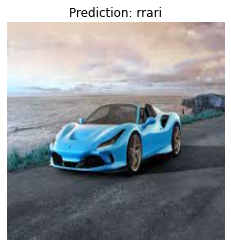

In [53]:
pred_and_plot(efficientnet_lambo_rrari_model, X_test/255., class_names)

## 4. What is the current best performing model on ImageNet?
* Hint: you might want to check sotabench.com for this.

Answer: CoCa: Contrastive Captioners are Image-Text Foundation Models